In [ ]:
!nvidia-smi

Sat May 29 07:40:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

---
# **IMAGE CAPTION**
---







### STEPS


1.   Data collection
2.   Understanding data
3.   Data cleaning
4.   Loading the train set
5.   Data preprocessing
6.   Data prepration using generator function
7.   Word embedding   
8.   model architecture
9.   train
7.   evaluation








In [ ]:
# we will crate function which read all text files
def read_text_files(path):

  file = open(path,'r')

  text = file.read()

  file.close()
  
  return text


In [ ]:
All_Captions = read_text_files("/content/drive/MyDrive/Flickr8k_text/Flickr8k.token.txt")
All_Captions = All_Captions.split("\n")

In [ ]:
All_Captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [ ]:
len(All_Captions)

40461

In [ ]:

img_id,img_desc = All_Captions[0].split("\t")

img_id = img_id.split('.')[0]


print(img_id)
print(img_desc)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [ ]:
#since we get to know on doing all_caption[-1] that last caption is empty
#so we delete this caption
All_Captions = All_Captions[:-1]
len(All_Captions)

40460

In [ ]:
# now we have captions, we will make ad dictionary now which contain image_id and all captions corresponding to it
# as each image consist 5 caption with it
# we will amke funtion for it

def load_description(captions):

  # will create a decription dictionary
  description_dict = {}

  # go through each captions
  for x in captions:

    #split out image id and description by "\t" as and then image_id by using split "."
    img_id,img_desc = x.split("\t")
    img_id = img_id.split('.')[0]

    # check if in=mg id present in dictionary or not if not create key and list corresponding to it
    if img_id not in description_dict:
      description_dict[img_id] = []
    
    # append all the description coreesponding to img_id in list
    description_dict[img_id].append(img_desc)

  return description_dict





In [ ]:
descriptions = load_description(All_Captions)
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

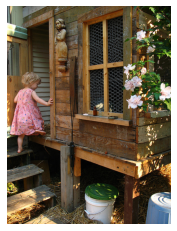

In [ ]:
# now we will draw image corresponding to discription we see in above cell to confirm our mappings
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("/content/drive/MyDrive/Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

# so yes our mapping is correct

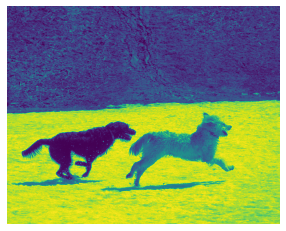

In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("/content/drive/MyDrive/Flickr8k_Dataset/Flicker8k_Dataset/2513260012_03d33305cf.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(img)
plt.axis("off")
plt.show()

### Clean Description

In [ ]:
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
puncuation = string.punctuation
puncuation=list(puncuation)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def clean_description(description):

  for img_id,desc_list in description.items():

    for i in range(len(desc_list)):

      desc = desc_list[i]

      # split sentence into word
      desc = word_tokenize(desc)

      # make every word in lower case
      desc = [word.lower() for word in desc]

      # remove puncuation
      desc = [word for word in desc if not word in puncuation]

      # remove word whose length is less than 1
      desc = [word for word in desc if len(word)>1]

      # remove numericals in sentences
      desc = [word for word in desc if word.isalpha()]

      desc_list[i] = " ".join(desc)


      

In [ ]:
clean_description(descriptions)

In [ ]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
f = open("/content/drive/MyDrive/Description_New_1.txt",'w')
f.write(str(descriptions))
f.close()

In [ ]:
# now we will create vocabulary
# so first open file
import json

discriptions = None
with open("/content/drive/MyDrive/Description_New_1.txt",'r') as f:
  descriptions = f.read()

# since it is in string format
print(type(descriptions))
# so will convert first it into dectionary form using jason method

json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)
print(type(descriptions))


<class 'str'>
<class 'dict'>


In [ ]:
def to_vocab(descriptions):
  vocab = set()

  for key in descriptions.keys():
    [vocab.update(d.split()) for d in descriptions[key]]
  return vocab

In [ ]:
vocab = to_vocab(descriptions)

In [ ]:
len(vocab)

8359

In [ ]:
# this vocab contain all unique set of words and we can see the size is 8359 thi huge 
# we can go with this vocab but insted of this we will reduce size by containing those word with max frequencies 
# this will help us to reduce computation power and overfitting

# first create a total word dictionary 

total_word = []
for key in descriptions.keys():
    [total_word.append(i) for d in descriptions[key] for i in d.split()]

len(total_word)


371906

In [ ]:
total_word[:10]

['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs']

In [ ]:
import collections

counter = collections.Counter(total_word) # this will count frequencies of each word
print(type(counter))
freq_cnt = dict(counter)

<class 'collections.Counter'>


In [ ]:
print(len(freq_cnt.keys()))

8359


In [ ]:
# sort this dectionary acc to frequency count
# in soreted function we have to pass list
# since list contain tuple of key and value pair so we have to sort acc to freq i.e value so use key 1
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key = lambda x:x[1])

sorted_freq_cnt[:10]

[('in', 18975),
 ('the', 18419),
 ('on', 10744),
 ('is', 9345),
 ('and', 8852),
 ('dog', 8136),
 ('with', 7765),
 ('man', 7266),
 ('of', 6713),
 ('two', 5639)]

In [ ]:
# now lets filter whose frequences is less then 10 we discard them
# lets called this barrier as threshold freq
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>=10]
total_word = [x[0] for x in sorted_freq_cnt]
len(total_word)
# so we can see lenth decrease to 1937 

1937

#### Now we will make train text data set

In [ ]:
train_text = read_text_files("/content/drive/MyDrive/Flickr8k_text/Flickr_8k.trainImages.txt")
test_text = read_text_files("/content/drive/MyDrive/Flickr8k_text/Flickr_8k.testImages.txt")

In [ ]:
train_text[-1]

'\n'

In [ ]:
# since we can see train_text is string file and the last one is new line 
# so we split this on new line expecting last one

train_id = [row.split('.')[0] for row in train_text.split("\n")[:-1]]
train_id[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [ ]:
test_id = [row.split('.')[0] for row in test_text.split("\n")[:-1]]

In [ ]:
# now we will make train_description dataset
# in this dataset each caption contain startseq and endseq which denote the start and end of caption
# we did this in model it will generate indefinate length caption

train_descriptions = {}
for img_id in train_id:
  train_descriptions[img_id] = []
  
  for caption in descriptions[img_id]:
    caption_to_be_added = 'startseq ' + caption + ' endseq'
    train_descriptions[img_id].append(caption_to_be_added)

train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### Now we will extrcat feature of image

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
import numpy as np

In [ ]:
IMG_PATH = "/content/drive/MyDrive/Flickr8k_Dataset/Flicker8k_Dataset"

def extract_feature(image_id):
  model = ResNet50(weights='imagenet',input_shape=(224,224,3))
  print(model.summary())
  model_new = Model(model.input,model.layers[-2].output)

  print(model_new.summary())

  features = dict()
  IMG_PATH = "/content/drive/MyDrive/Flickr8k_Dataset/Flicker8k_Dataset"

  for id in image_id:
    img_path = IMG_PATH + "/" + id + ".jpg"
    img = load_img(img_path,target_size=(224,224))


    img = img_to_array(img)

    img = img.reshape(1,img.shape[0],img.shape[1],img.shape[2])
    # we can also use np.expand_dims(img,axis=0)

    img = preprocess_input(img)

    feature = model_new.predict(img)
    #since this will return 2d shape of [1,2048]
    #so we reshape it in 1d i.e 2048

    feature = feature.reshape((-1,))

    features[id]=feature

  return features



In [ ]:
train_img_feature = extract_feature(train_id)

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_14[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
print(len(train_img_feature.keys()))
print(len(train_img_feature['2513260012_03d33305cf']))
len(train_id)


6000
2048


6000

In [ ]:
# save the train_features in disk
from pickle import dump
with open("/content/drive/MyDrive/extracted_train_feature.pkl","wb") as f:
  dump(train_img_feature,f)

In [ ]:
test_img_feature = extract_feature(test_id)

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
print(len(test_img_feature.keys()))
len(test_id)


1000


1000

In [ ]:
with open("/content/drive/MyDrive/extracted_test_feature.pkl","wb") as f:
  dump(test_img_feature,f)

### Now we will do caption pre processing

In [ ]:
# we will create a dictionary which contain index corresponding to each word 
# we will also create dictionary which contain word correspomding to all index

# we will domthis a model accept numerical data not text data

word_to_index = {}
index_to_word = {}

for i,word in enumerate(total_word):
  word_to_index[word] = i+1  # we didn't use 0 as index b/c we have to fill non present word with 0
  index_to_word[i+1] = word

In [ ]:
print(index_to_word[6])
len(word_to_index)

dog


1937

In [ ]:
# we have to add index corresponding to startseq and endseq also
word_to_index['startseq'] = 1938
index_to_word[1938] = 'startseq'
word_to_index['endseq'] = 1939
index_to_word[1939] = 'endseq'
vocab_size = len(word_to_index)+1 # 1 for 0th index also


In [ ]:
vocab_size
# voacb_size = 1940

1940

In [ ]:
# now we find maximum length caption

max_len=0
for id in train_descriptions.keys():
  for cap in train_descriptions[id]:
    max_len = max(max_len,len(cap.split()))

In [ ]:
max_len

33

In [ ]:
max_len = 33
vocab_size = 1940
# we will save them for further use so that we didn't have to run prior code

In [ ]:
from pickle import dump
with open("/content/drive/MyDrive/word_to_index.pkl","wb") as f:
  dump(word_to_index,f)


with open("/content/drive/MyDrive/index_to_word.pkl","wb") as f:
  dump(index_to_word,f)

### Now we will create data generator function

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
def data_generator(train_descriptions,image_feature,word_to_index,max_len,vocab_size,batch_size):
  x1,x2,y = [],[],[]

  n=0 #for maintain a counter for batch size
  while True:
    for key,desc_list in train_descriptions.items():
      n+=1

      photo = image_feature[key]

      for desc in desc_list:

        seq = [word_to_index[word] for word in desc.split() if word in word_to_index]

        for i in range(1,len(seq)):
          xi = seq[0:i]
          yi = seq[i]

          xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
          yi = to_categorical([yi],num_classes=vocab_size)[0]

          x1.append(photo)
          x2.append(xi)
          y.append(yi)

        if n==batch_size:
          yield ([np.array(x1),np.array(x2)],np.array(y))
          x1,x2,y =[],[],[]
          n=0




### Now we will make embedding matrix

**we can also use embedding layer from keras but we use pre trained glove vector to make embedding matrix**

In [ ]:
import numpy as np
f = open("/content/drive/MyDrive/glove.6B.50d.txt",encoding='utf8')


In [ ]:
# first we make embedding vector dictionary to map each word with its 50 dimensional vector
embedding_vectors = {}

for line in f:
  values = line.split()
  word = values[0]
  vector = np.array(values[1:],dtype='float')
  embedding_vectors[word] = vector

In [ ]:
embedding_vectors['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [ ]:
# we we don't need all words we need only those word which are present in our vocab
def get_embedding_matrix():
  vector_dimension = 50 # we know that
  matrix = np.zeros((vocab_size,vector_dimension))

  for word,index in word_to_index.items():
    vector = embedding_vectors.get(word) # it doesn't give error if word is not present

    if vector is not None:
      matrix[index] = vector

  return matrix


In [ ]:
embedding_matrix = get_embedding_matrix()

In [ ]:
embedding_matrix[1938] # for 1938 index word is startseq and as it not present in glove dataset do we get 50 dimension zeros vector

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Model architecture

In [ ]:
from keras.layers import *
from keras.models import Model

In [ ]:
# model to process image feature in more dense form give 256 vector of img_feature from 2048
img_feature_input = Input(shape=(2048,))
input_1 = Dropout(0.3)(img_feature_input)
input_2 = Dense(256,activation='relu')(input_1) 

In [ ]:
# model to process caption
caption_input = Input(shape=(max_len,))
input_cap_1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(caption_input)
input_cap_2 = Dropout(0.3)(input_cap_1)
input_cap_3 = LSTM(256)(input_cap_2)

In [ ]:
# now add both model outputs
decoder_1 = add([input_2,input_cap_3])
decoder_2 = Dense(256,activation='relu')(decoder_1)
outputs = Dense(vocab_size,activation='softmax')(decoder_2)

In [ ]:
# combined model
model = Model(inputs=[img_feature_input,caption_input],outputs=outputs)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 33)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 33, 50)       97000       input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
# since we already make embedding matrix using pre trained glove vector so we don't tarin enbedding layer and intialize weights with 
# weights or vector of embedding matrix

# since embedding layer presen at 2 index (can be seen from model summary)
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 33)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 33, 50)       97000       input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

## Train Model

In [ ]:
from pickle import load

train_feature = load(open('/content/drive/MyDrive/extracted_train_feature.pkl','rb'))

In [ ]:
batch_size = 3
epochs = 20
steps = len(train_descriptions)//btach_size

for i in range(epochs):
  generator = data_generator(train_descriptions,train_feature,word_to_index,max_len,vocab_size,batch_size)
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
  model.save('/content/drive/MyDrive/model_weights/model_caption_'+str(i+20)+'.h5')

   8/2000 [..............................] - ETA: 31s - loss: 2.4103

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


   1/2000 [..............................] - ETA: 42s - loss: 1.8965

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


2000/2000 [==============================] - 29s 15ms/step - loss: 2.4085


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


TypeError: ignored